# Exploratory Data Analysis of Drillhole and Surface Copper Assay Datasets

## 1. Project Overview

This notebook presents an exploratory data analysis (EDA) of four geoscientific datasets from Western Australia, supporting mineral exploration efforts. The datasets include original laboratory copper assay results and deep-learning-based imputed values for both drillhole and surface samples.

**Objective:**  
To compare the original and imputed datasets, characterize their spatial and statistical properties, identify data quality issues, and lay the foundation for further geostatistical and visualization work.

## 2. Dataset Description

- **Cu_ppm_Orig_DH_SOWETO:** Original copper assays for drillhole samples
- **Cu_ppm_DL_DH_SOWETO:** Deep-learning imputed copper values for drillhole samples (imputed where Cu was not originally analyzed)
- **Cu_ppm_Orig_S_SOWETO:** Original copper assays for surface samples
- **Cu_ppm_DL_S_SOWETO:** Deep-learning imputed copper values for surface samples

Each dataset includes:
- A unique sample identifier (`SAMPLEID`)
- Spatial coordinates (latitude/longitude)
- Sample type and (for drillholes) depth intervals
- Copper concentration in ppm (`Cu_ppm`)



## 3. Data Loading and Initial Inspection

In [1]:
import pandas as pd

#Load all datasets (CSV format)
df_dh_orig = pd.read_csv('Cu_ppm_Orig_DH_SOWETO.csv')
df_dh_dl   = pd.read_csv('Cu_ppm_DL_DH_SOWETO.csv')
df_surf_orig = pd.read_csv('Cu_ppm_Orig_S_SOWETO.csv')
df_surf_dl   = pd.read_csv('Cu_ppm_DL_S_SOWETO.csv')

In [2]:
#Display basic info and column names for each dataset
for name, df in [
    ('Drillhole Original', df_dh_orig), 
    ('Drillhole DNN', df_dh_dl),
    ('Surface Original', df_surf_orig), 
    ('Surface DNN', df_surf_dl)
]:
    print(f"{name}: shape={df.shape}, columns={df.columns.tolist()}")
    print(df.head(2))

Drillhole Original: shape=(6429144, 9), columns=['SAMPLEID', 'LATITUDE', 'LONGITUDE', 'SAMPLETYPE', 'COLLARID', 'FROMDEPTH', 'TODEPTH', 'Cu_ppm', 'SPURIOUS']
   SAMPLEID   LATITUDE  LONGITUDE SAMPLETYPE  COLLARID  FROMDEPTH  TODEPTH  \
0  11226292 -27.931236  116.04225    DRILLRC    554128       56.0     60.0   
1  11226293 -27.931236  116.04225    DRILLRC    554128       60.0     64.0   

   Cu_ppm  SPURIOUS  
0    32.0         0  
1    83.0         0  
Drillhole DNN: shape=(920576, 8), columns=['SAMPLEID', 'LATITUDE', 'LONGITUDE', 'SAMPLETYPE', 'COLLARID', 'FROMDEPTH', 'TODEPTH', 'Cu_ppm']
   SAMPLEID   LATITUDE  LONGITUDE  SAMPLETYPE  COLLARID  FROMDEPTH  TODEPTH  \
0  38013318 -33.359524  121.86429  DRILLSONIC   1646815       26.0     33.5   
1  38013319 -33.356274  121.87158  DRILLSONIC   1646816       23.0     27.0   

   Cu_ppm  
0  18.932  
1  21.117  
Surface Original: shape=(993385, 6), columns=['SAMPLEID', 'DLAT', 'DLONG', 'SAMPLETYPE', 'Cu_ppm', 'SPURIOUS']
   SAMPLEID     

### Goal:
Check dataset size and preview the schema.

### Interpretation:
We confirmed the column structures are as expected, and see that each dataset contain millions of records.

## 4. Data Quality Check & Missing Values
### Goal:
Identify and quantify missing or invalid values, especially in the Cu_ppm field. In these datasets, missing values are encoded with extreme placeholders (e.g., -9999900, -9999999, -298514).

In [3]:
#Count missing and placeholder value in Cu_ppm for each dataset
for name, df in [
    ('Drillhole Original', df_dh_orig), 
    ('Drillhole DNN', df_dh_dl),
    ('Surface Original', df_surf_orig), 
    ('Surface DNN', df_surf_dl)
]:
    n_missing = (df['Cu_ppm'] <= 0).sum()
    print(f"{name}: Total records = {len(df)}, Cu_ppm missing/invalid = {n_missing}")

Drillhole Original: Total records = 6429144, Cu_ppm missing/invalid = 3962111
Drillhole DNN: Total records = 920576, Cu_ppm missing/invalid = 0
Surface Original: Total records = 993385, Cu_ppm missing/invalid = 12038
Surface DNN: Total records = 545382, Cu_ppm missing/invalid = 0


### Interpretation:
Drillhole original data contains a large number of missing or invalid Cu_ppm entries, while the DNN-imputed datasets are almost fully populated with positive values.

## 5. Filtering for Valid Observations
### Goal:
For all statistical analysis, we exclude samples with missing, zero, or extreme (negative) Cu_ppm values.

In [4]:
#Keep only records with reasonable, positive copper ppm values
df_dh_orig_valid = df_dh_orig[(df_dh_orig['Cu_ppm'] > 0) & (df_dh_orig['Cu_ppm'] < 10000)]
df_dh_dl_valid = df_dh_dl[(df_dh_dl['Cu_ppm'] > 0) & (df_dh_dl['Cu_ppm'] < 10000)]
df_surf_orig_valid = df_surf_orig[(df_surf_orig['Cu_ppm'] > 0) & (df_surf_orig['Cu_ppm'] < 10000)]
df_surf_dl_valid = df_surf_dl[(df_surf_dl['Cu_ppm'] > 0) & (df_surf_dl['Cu_ppm'] < 10000)]

print("Valid drillhole observations:", len(df_dh_orig_valid))
print("Valid surface observations:", len(df_surf_orig_valid))

Valid drillhole observations: 2459773
Valid surface observations: 980934


### Interpretation:
Filtering removes placeholder and extreme values. Drillhole original data is particularly sparse after filtering, highlighting the importance of imputation.

## 6. Statistical Summary of Valid Copper Assays
### Goal:
Summarize and compare copper concentrations in original and DNN-imputed datasets.

In [5]:
for label, df in [
    ("Drillhole Original", df_dh_orig_valid), 
    ("Drillhole DNN", df_dh_dl_valid),
    ("Surface Original", df_surf_orig_valid), 
    ("Surface DNN", df_surf_dl_valid)
]:
    print(f"\n{label} Cu_ppm summary:\n{df['Cu_ppm'].describe()}")


Drillhole Original Cu_ppm summary:
count    2.459773e+06
mean     1.719805e+02
std      5.205560e+02
min      1.000000e-04
25%      2.000000e+01
50%      5.000000e+01
75%      1.200000e+02
max      9.990000e+03
Name: Cu_ppm, dtype: float64

Drillhole DNN Cu_ppm summary:
count    920093.000000
mean         50.771368
std         114.839932
min           0.002000
25%          12.389000
50%          28.820000
75%          67.054000
max        9862.415000
Name: Cu_ppm, dtype: float64

Surface Original Cu_ppm summary:
count    980934.000000
mean         36.949742
std         129.388620
min           0.000100
25%           6.240000
50%          21.000000
75%          45.000000
max        9960.000000
Name: Cu_ppm, dtype: float64

Surface DNN Cu_ppm summary:
count    544464.000000
mean         30.157707
std         139.415823
min           0.001000
25%          12.792000
50%          21.107000
75%          28.520000
max        9763.723000
Name: Cu_ppm, dtype: float64


### Interpretation:

After filtering out placeholder values and extreme outlier, the copper concentration in both original and DNN-imputed datasets falls within a geologically reasonable range (0–10,000 ppm).
DNN imputations provide a more conservative, less variable estimate of copper value, specially for locations with no original laboratory measurement. This data cleaning step is crucial for meaningful comparison, visualization, and subsequent geostatistical analysis.

## 7. Spatial Distribution Visualization
### Goal:
Visualize the geographic coverage of original and imputed samples, and assess how well DNN imputation fills spatial data gaps.

F:\ANACONDA3\envs\geo-cu\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


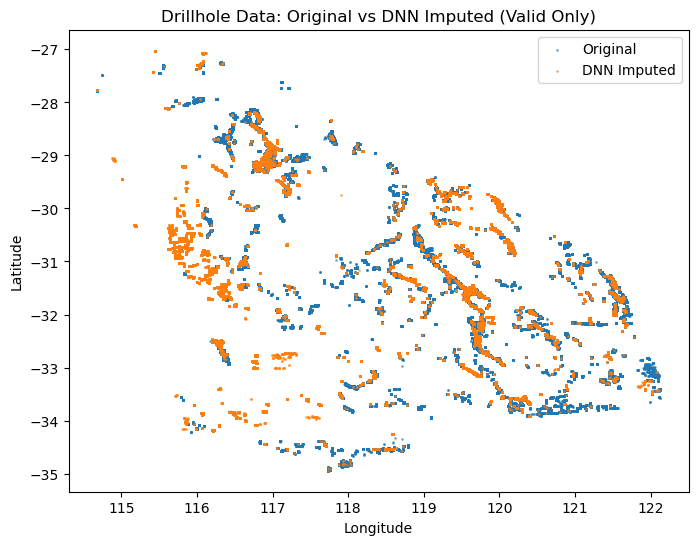

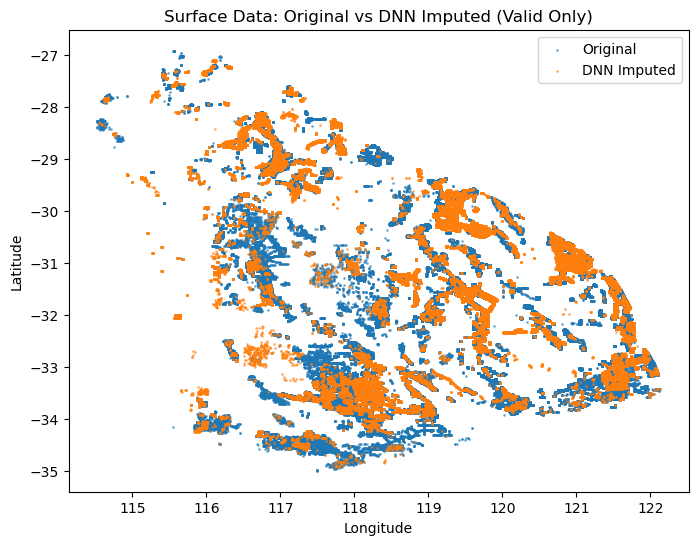

In [6]:
import matplotlib.pyplot as plt

#Drillhole data spatial coverage
plt.figure(figsize=(8,6))
plt.scatter(df_dh_orig_valid['LONGITUDE'], df_dh_orig_valid['LATITUDE'], 
            s=1, label='Original', alpha=0.5)
plt.scatter(df_dh_dl_valid['LONGITUDE'], df_dh_dl_valid['LATITUDE'], 
            s=1, label='DNN Imputed', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Drillhole Data: Original vs DNN Imputed (Valid Only)')
plt.legend()
plt.show()

#Surface data spatial coverage
plt.figure(figsize=(8,6))
plt.scatter(df_surf_orig_valid['DLONG'], df_surf_orig_valid['DLAT'], 
            s=1, label='Original', alpha=0.5)
plt.scatter(df_surf_dl_valid['DLONG'], df_surf_dl_valid['DLAT'], 
            s=1, label='DNN Imputed', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Data: Original vs DNN Imputed (Valid Only)')
plt.legend()
plt.show()

### Interpretation:

The DNN-imputed datasets provide additional spatial coverage, particularly in regions with limited or missing original assays.
This supports the project's aim of revealing hidden exploration targets by filling analytical gaps.

## 8. Value Distribution Visualization
### Goal:
Compare the statistical distributions of copper concentrations across the datasets.

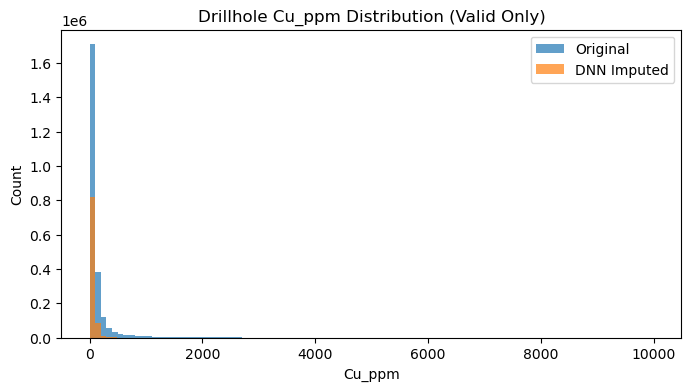

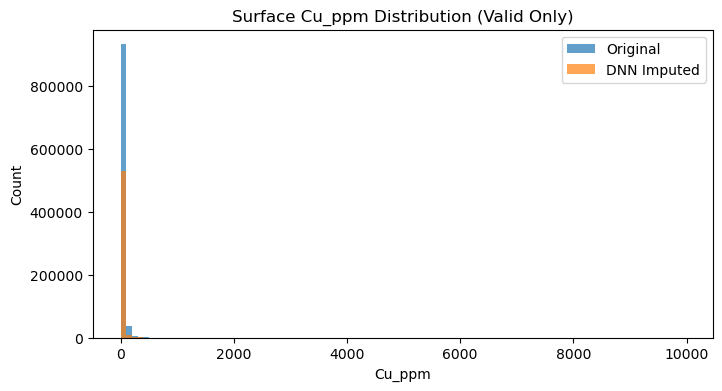

In [7]:
#Histogram for drillhole data
plt.figure(figsize=(8,4))
plt.hist(df_dh_orig_valid['Cu_ppm'], bins=100, alpha=0.7, label='Original')
plt.hist(df_dh_dl_valid['Cu_ppm'], bins=100, alpha=0.7, label='DNN Imputed')
plt.xlabel('Cu_ppm')
plt.ylabel('Count')
plt.title('Drillhole Cu_ppm Distribution (Valid Only)')
plt.legend()
plt.show()

#Histogram for surface data
plt.figure(figsize=(8,4))
plt.hist(df_surf_orig_valid['Cu_ppm'], bins=100, alpha=0.7, label='Original')
plt.hist(df_surf_dl_valid['Cu_ppm'], bins=100, alpha=0.7, label='DNN Imputed')
plt.xlabel('Cu_ppm')
plt.ylabel('Count')
plt.title('Surface Cu_ppm Distribution (Valid Only)')
plt.legend()
plt.show()

### Interpretation:

Original datasets contain a wider range of copper values and occasional outlier.
DNN-imputed values are generally lower and more tightly clustered, which may reflect conservative estimation by the model.

## 9.Conclusions and Recommendations
### Data Quality:
Substantial missing data exists in original drillhole assays; DNN imputation provides valuable spatial and analytical supplementation.

### Spatial Coverage:
Imputation effectively fills geographic gaps, supporting exploration in previously under-sampled regions.

### Value Distribution:
DNN-imputed values are less variable and more conservative than original assays. The lack of overlapping records prevents direct error/residual analysis; further work could involve model validation at observed locations if possible.

### Next Steps we may be interested in:

Conduct stratified or region-based summaries (e.g., by geological unit or exploration block)
Explore interactive or 3D visualizations of spatial Cu_ppm patterns


## Appendix: Data Cleaning and Filtering Functions


In [8]:
def filter_valid_cu(df, col='Cu_ppm', minval=0, maxval=10000):
    """Filter DataFrame for reasonable Cu_ppm values only."""
    return df[(df[col] > minval) & (df[col] < maxval)].copy()
